In [1]:
# import des librairies dont nous aurons besoin
import pandas as pd
import pprint
import numpy as np
import re
import missingno as msno 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sms
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate


# chargement et affichage des données
data = pd.read_csv('df2020_2021.csv')

Vous travaillez pour une entreprise qui crée des rééditions d’albums de musique légendaires au format vinyle

En se basant sur les caractéristiques musicales d’un morceau, est ce qu’un tube sorti il y a des années et qui est devenu un classique aurait connu le même succès s’il avait été sorti récemment

étudier le lien entre les caractéristiques musicales des morceaux sortis en 2022 et leur popularité pour appliquer ce modèle à n’importe morceau de l’histoire de la musique et en particulier du catalogue de votre entreprise

In [2]:
data.head()

,popularity,duration_ms,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,41,159560,2020-03-13,0.671,0.867,2,-2.706,1,0.0571,0.436,0.000000,0.1390,0.839,120.689,4
1,18,313093,2020-10-30,0.644,0.212,11,-14.118,1,0.0347,0.881,0.000022,0.7980,0.441,117.072,3
2,18,295093,2020-10-30,0.627,0.184,1,-15.533,1,0.0450,0.955,0.000162,0.0986,0.299,115.864,4
3,17,147907,2020-10-30,0.442,0.399,6,-12.661,1,0.0780,0.930,0.000499,0.9120,0.554,121.662,4
4,17,183440,2020-10-30,0.581,0.331,6,-14.087,1,0.2430,0.888,0.000015,0.1470,0.642,88.303,4


In [26]:
X= data.drop(columns=['popularity','release_date'],axis=1)
y= data[['popularity']]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.15, random_state=42 )

In [28]:
# AJOUTER , stratify= data[''] ???

In [29]:
cols_to_norm = ['duration_ms', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']
col_cat = ['mode']
scale_one_hot = ColumnTransformer(
    [('scaler',  StandardScaler(), cols_to_norm),
    ('one_hot_encoder', OneHotEncoder(), col_cat)
])

preprocessor = Pipeline([
    ('normalizer', scale_one_hot)
    # autres étapes de votre pipeline ici
])
# Transformation des données

preprocessor.fit_transform(X_train, y_train)

array([[ 2.97927211e-01,  7.23972862e-01, -1.30324808e-01, ...,
         1.49032769e-01,  1.00000000e+00,  0.00000000e+00],
       [ 1.03087566e+00,  3.46798108e-01,  2.64344974e-01, ...,
         1.49032769e-01,  1.00000000e+00,  0.00000000e+00],
       [ 1.38102767e-01, -1.46236215e+00,  1.23178586e-03, ...,
         1.49032769e-01,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 9.83131244e-01, -7.65547774e-01, -3.39840865e-01, ...,
         1.49032769e-01,  0.00000000e+00,  1.00000000e+00],
       [-4.88530800e-01, -9.89295509e-01,  1.11702660e+00, ...,
         1.49032769e-01,  0.00000000e+00,  1.00000000e+00],
       [ 1.33280581e-01,  4.10726033e-01,  7.17484353e-01, ...,
         1.49032769e-01,  1.00000000e+00,  0.00000000e+00]])

In [58]:
my_pipe_lr = make_pipeline(preprocessor, PolynomialFeatures(degree=2), Lasso(random_state=42, max_iter=10000))
my_pipe_lr.fit(X_train, y_train)
pipe_lr = cross_validate(my_pipe_lr, X_train, y_train, cv=5, scoring= ['r2', 'neg_root_mean_squared_error'])

In [59]:
score_lr = pipe_lr['test_r2'].mean()
rmse_lr = np.abs(pipe_lr['test_neg_root_mean_squared_error'].mean())
print(score_lr,rmse_lr)


0.20132398851199448 22.77270298294328


In [64]:
from sklearn.metrics import mean_absolute_error

In [63]:
y_pred = my_pipe_lr.predict(X_train)

In [67]:
mean_absolute_error(y_train, y_pred)

18.52473451384957

In [60]:
mae_lr = np.abs(my_pipe_lr['neg_mean_absolute_error'])
mae_lr

KeyError: 'neg_mean_absolute_error'

In [69]:
hyperparametres = {'lasso__alpha': [0.01,0.1, 0.2,0.5, 1,10,100]}
random_search = RandomizedSearchCV(my_pipe_lr, hyperparametres, cv=5)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

grid_search = GridSearchCV(my_pipe_lr, hyperparametres, cv= 10, scoring='neg_mean_absolute_error')
grid_search.fit(X_train,y_train)


my_pipe_lr.set_params(**grid_search.best_params_)
lasso_score = grid_search.best_score_
lasso_score

/home/yanis/miniconda3/envs/segmentation_client/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


-17.565011171199252

In [ ]:
from sklearn.model_selection import learning_curve

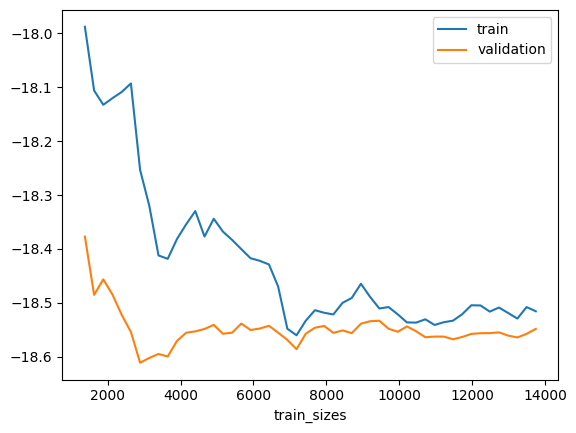

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(my_pipe_lr,X_train,y_train,cv=5,train_sizes=np.linspace(0.1, 1.0, 50), scoring = 'neg_mean_absolute_error')                                    
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [70]:
import pycaret

ModuleNotFoundError: No module named 'pycaret'

forêts aléatoires pour prédire le succès des chansons, d'abord en fonction de leurs caractéristiques acoustiques

idée de colonne:
chanteur ou chanteuse?
superstar : nous informant si l'artiste de la chanson était apparu dans les meilleurs classements dans un passé proche

